# Paper Reproduction

## Goal of the project
Reproduce the results from the paper "Predicting the direction of stock market prices using random forest."

## Import Libraries

In [14]:
pip install import-ipynb

Note: you may need to restart the kernel to use updated packages.


In [15]:
import import_ipynb
import technical_indicators as ta

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger

import numpy as np
import random

#Let's make this notebook reproducible 
np.random.seed(42)
random.seed(42)

#import techinal_indicators as ta #https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py

import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

## Data


In [59]:
aapl = pd.read_csv('AAPL(RF).csv')
aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-03-31,33.641430,33.801430,33.494286,33.571430,22.726398,107664900
1,2010-04-01,33.915714,34.104286,33.250000,33.709999,22.820208,150786300
2,2010-04-05,33.568573,34.072857,33.538570,34.070000,23.063911,171126900
3,2010-04-06,34.028572,34.320000,33.857143,34.220001,23.165457,111754300
4,2010-04-07,34.221428,34.560001,34.094284,34.371429,23.267965,157125500


## Exponential smoothing

In [18]:
def get_exp_preprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()    
    return edata

In [19]:
saapl = get_exp_preprocessing(aapl)
saapl.head() #saapl stands for smoothed aapl

C:\Users\30683\AppData\Local\Temp\ipykernel_27392\2838536098.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  edata = df.ewm(alpha=alpha).mean()


,Open,High,Low,Close,Adj Close,Volume
0,33.641430,33.801430,33.494286,33.571430,22.726398,1.076649e+08
1,33.890779,34.076754,33.272208,33.697402,22.811680,1.468662e+08
2,33.600503,34.073243,33.512174,34.033076,23.038915,1.687227e+08
3,33.985804,34.295347,33.822677,34.201325,23.152814,1.174460e+08
4,34.197868,34.533538,34.067126,34.354420,23.256451,1.531579e+08


## Feature Extraction - Technical Indicators

In [20]:
def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.accumulation_distribution(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.money_flow_index(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.on_balance_volume(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.ease_of_movement(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
        
    #Williams %R is missing
    data = ta.macd(data, n_fast=12, n_slow=26)
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data
   
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon]
    data['pred'] = compute_prediction_int(data, n=horizon)
    del(data['Close'])
    return data.dropna()

## Prepare the data with a prediction horizon of 10 days

In [21]:
data = prepare_data(saapl, 10)

y = data['pred']

#remove the output from the input
features = [x for x in data.columns if x not in ['gain', 'pred']]
X = data[features]


### Make sure that future data is not used by splitting the data in first 2/3 for training and the last 1/3 for testing

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2*len(X) // 3)

print('len X_train', len(X_train))
print('len y_train', len(y_train))
print('len X_test', len(X_test))
print('len y_test', len(y_test))

len X_train 644
len y_train 644
len X_test 323
len y_test 323


## LSTM

In [71]:
import pandas as pd
import yfinance as yf
stock_data = yf.download('AAPL', start='2010-03-31', end='2014-12-09')

import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

[*********************100%***********************]  1 of 1 completed


In [72]:
def LSTMModel():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

Text(0, 0.5, 'Prices')

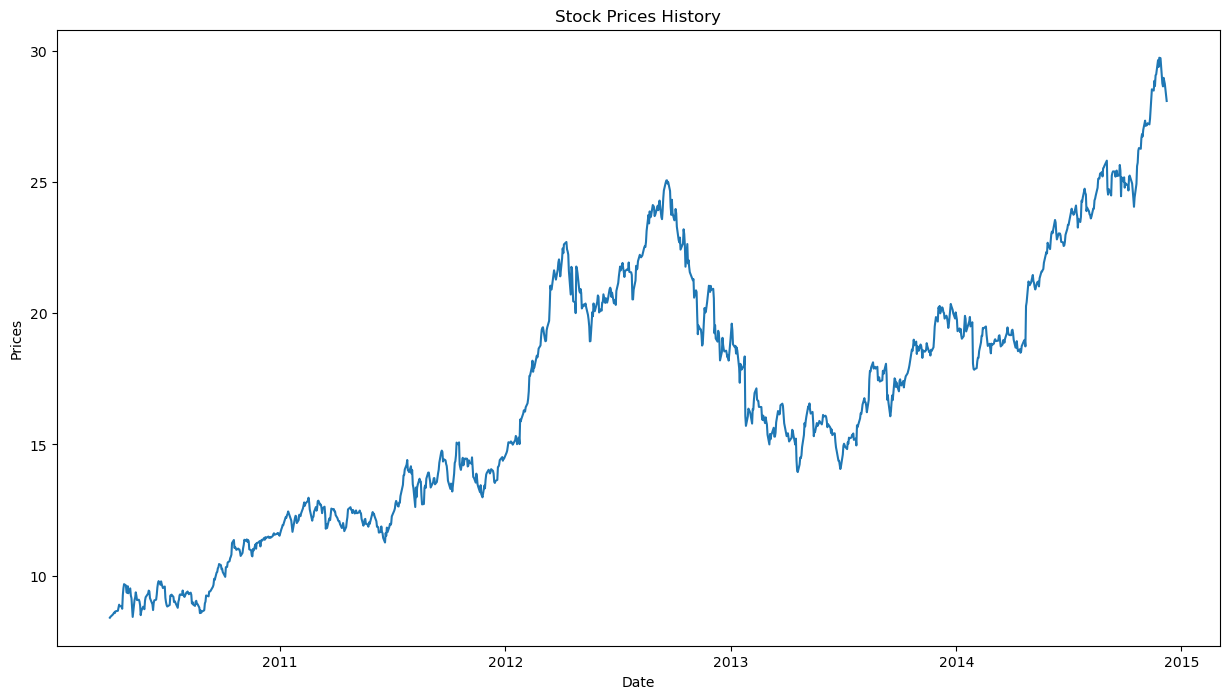

In [73]:
plt.figure(figsize=(16, 10))
plt.title('Stock-Prices-History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices')


In [74]:
close_prices = aapl['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [75]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [76]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 25)                2525      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
887/887 [==============================] - 25s 24ms/step - loss: 0.0022
Epoch 2/3
887/887 [==============================] - 23s 26ms/step - loss: 7.9325e-04
Epoch 3/3
887/887 [==============================] - 22s 25ms/step - loss: 5.8808e-04


In [78]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 1s 20ms/step


1.2925867184727553

C:\Users\30683\AppData\Local\Temp\ipykernel_27392\3110116222.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


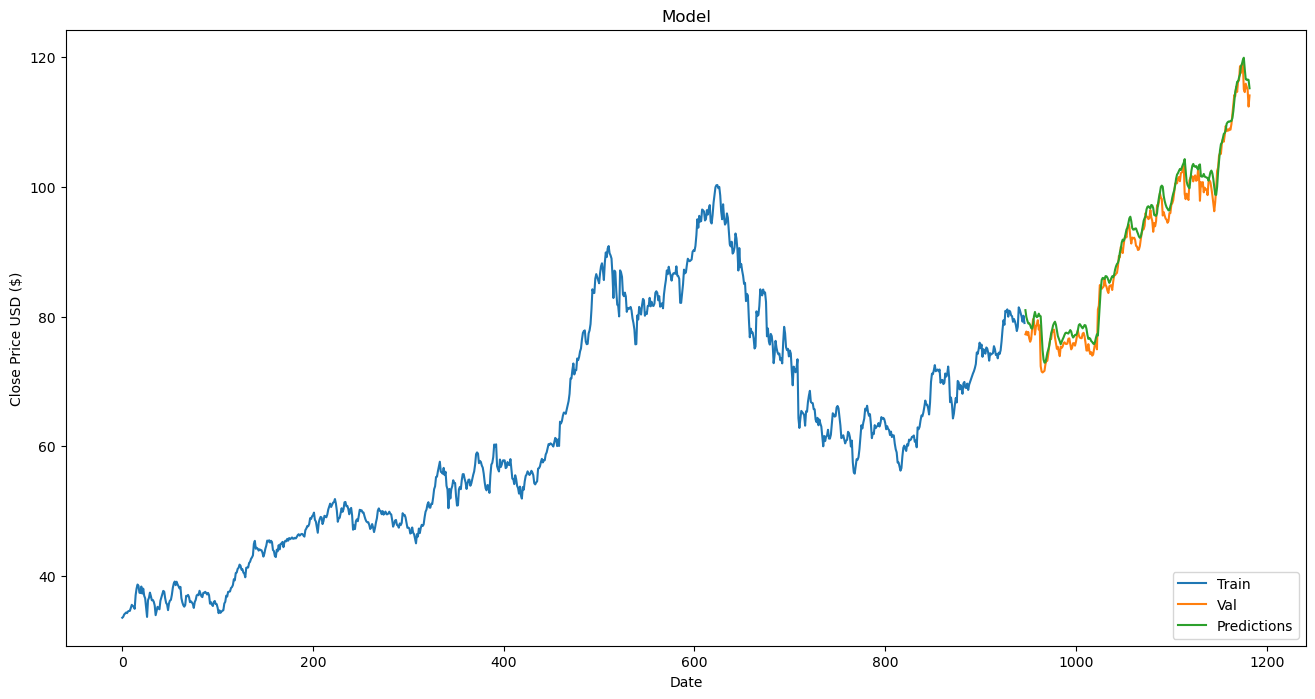

In [79]:
data = aapl.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [221]:
#precision = precision_score(y_pred=predictions, y_true=y_test)
predictions.resize(236)



## Random Forests

In [195]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf.fit(X_train, y_train.values.ravel());

The expected results for a 10 days prediction according to the paper in table 15 for Apple stock should be around 92%

In [198]:
pred = rf.predict(X_test)print(y_test)print(pred)
print(y_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')


print(confusion)

SyntaxError: invalid syntax (2638208557.py, line 1)

#### The accuracy results almost match those expected from the paper 86% vs the expected 92%

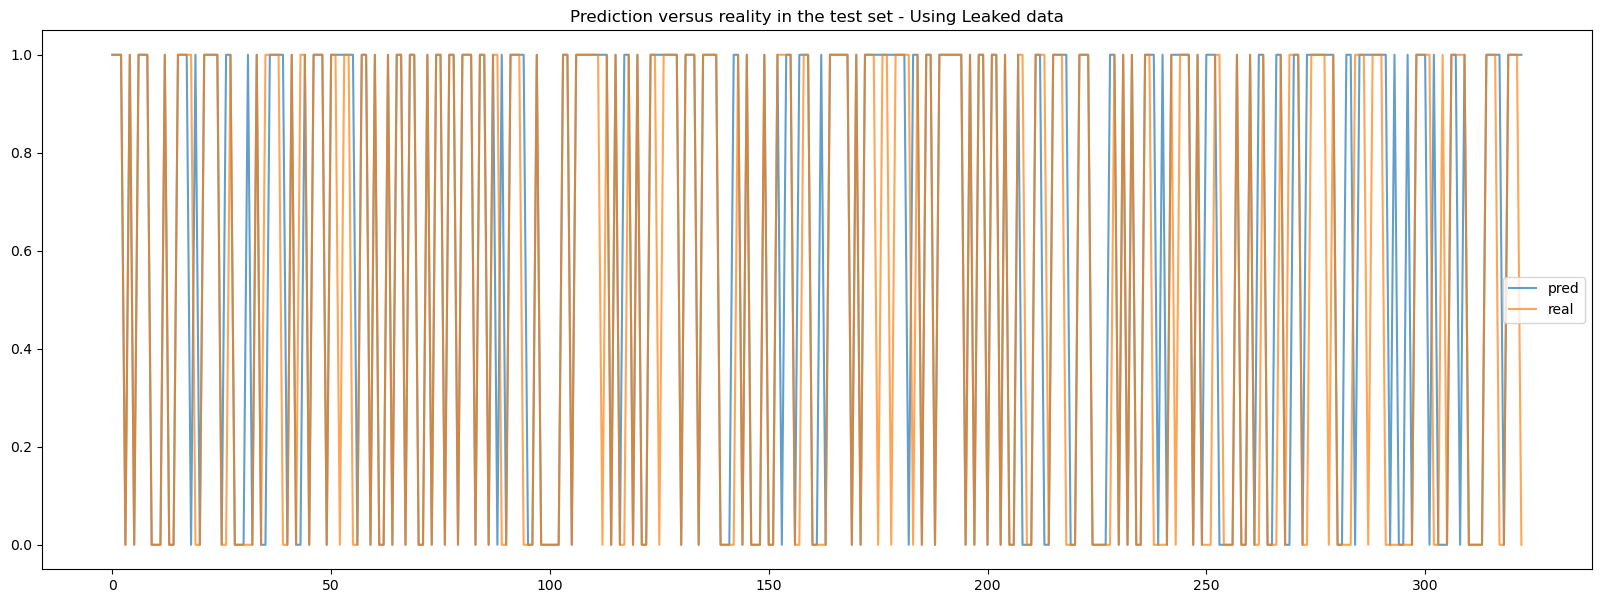

In [14]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred, alpha=0.7, label='pred')
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='real' );
plt.title('Prediction versus reality in the test set - Using Leaked data')
plt.legend();

<Figure size 2000x700 with 0 Axes>

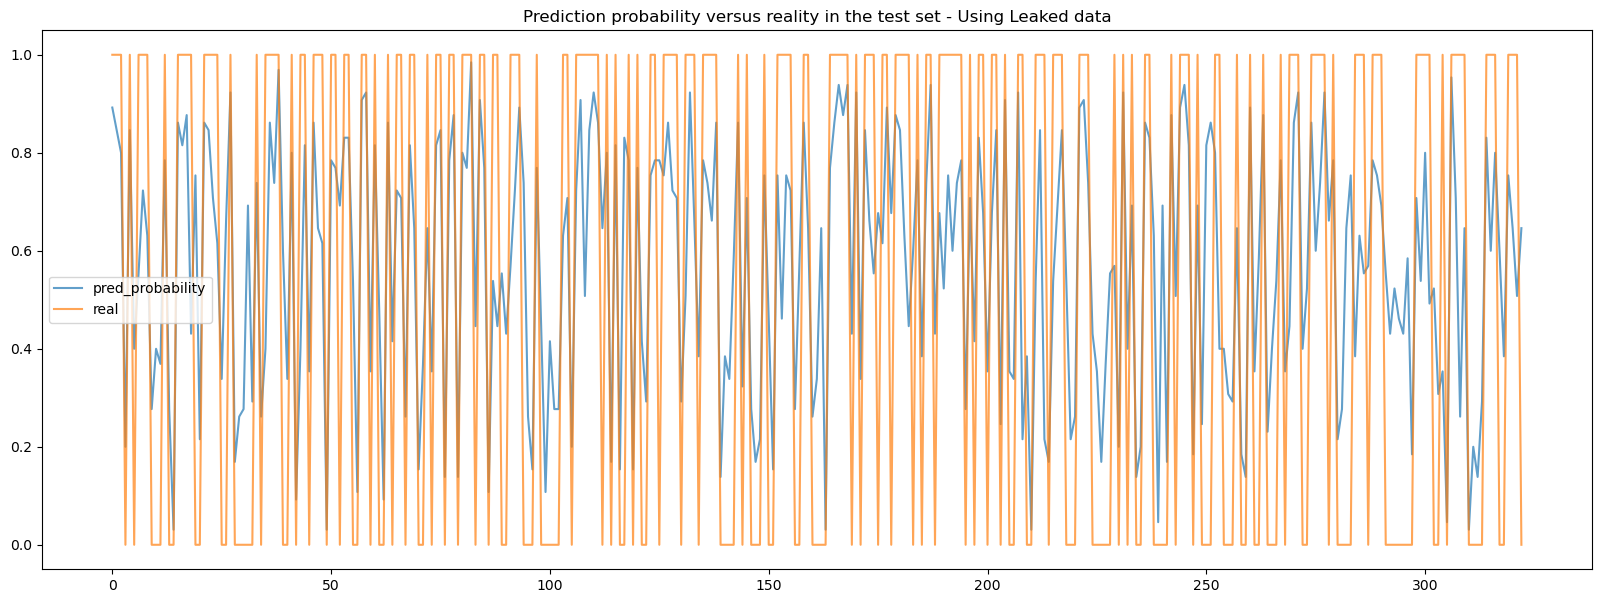

In [15]:
plt.figure(figsize=(20,7))
proba = rf.predict_proba(X_test)[:,1]
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(proba)), proba, alpha = 0.7, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, alpha = 0.7, label='real' );
plt.title('Prediction probability versus reality in the test set - Using Leaked data');
plt.legend();
plt.show();

### Comments on Data Leaked results
The results with the data leakage approach are much more in line with those reported by the paper. In the paper it was reported a 92% accuracy for Apple, while this analysis yields 87% instead. This could be for a number of reasons including:
* the feature Williams %R was not computed
* the value for alpha was set to 0.9, but we don't know what alpha was used
* the value n for several of the technical indicators was not known, and we opted for try several values for 'n'
* more technical indicators were used in the hope that they could contribute to even better results

This analysis seems to indicate that the results from the original paper suffer from data leakage. Please, let me know if you notice any mistake in the analysis / code or if you feel there is something I misunderstood.
